# ML 2 - Perceptron

- Name: Gelli Mae Gloria
- Start Date: December 14, 2020
- End Date: January 13, 2021
- Student Number: 2015-06435

### I - Dataset Cleaning

### A. Preliminaries
Import all important packages from Python: 
* **Pandas**: Reading and loading the file; make dataframes 
* **Numpy**: For multidimensional array and operations on arrays
* **Matplotlib/Seaborn**: For our visualizations
* **Random**: For the initialization of the random number generator for the weights

In [1]:
# Import important packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from random import seed

from cvxopt import matrix

In [2]:
# Create dataframe for each fruit class

mango = pd.read_excel('ML_dataset.xlsx', sheet_name = 'Class 1 - Mango')
orange = pd.read_excel('ML_dataset.xlsx', sheet_name = 'Class 2 - Orange')
banana = pd.read_excel('ML_dataset.xlsx', sheet_name = 'Class 3 - Banana')
mango = pd.DataFrame(mango)
orange = pd.DataFrame(orange)
banana = pd.DataFrame(banana)
orange.head()

,Image,R,G,B,Hue,StDev,Median,Skew,AR,Round
0,1,236.764,200.613,153.233,34.032874,33.247,138,0.660,1.025,0.976
1,2,245.911,266.276,179.424,78.378029,37.526,156,0.758,1.010,0.990
2,3,116.534,109.282,18.273,55.571793,28.342,115,0.587,1.681,0.595
3,4,220.972,215.616,191.501,49.095721,32.131,147,0.943,1.130,0.885
4,5,249.121,206.316,122.162,39.770635,20.441,151,1.635,1.037,0.965


### B. Hue
We introduce a function called **hue** to calculate the hue from our RGB values. The function follows the following constraints:
* If Red is max, then Hue = (G-B)/(max-min)
* If Green is max, then Hue = 2.0 + (B-R)/(max-min)
* If Blue is max, then Hue = 4.0 + (R-G)/(max-min)

In [3]:
def hue(R,G,B):
    vals = [R, G, B]
    max_vals = max(vals)
    min_vals = min(vals)
    
    if max_vals == R:
        hue = 60 * (G-B)/(max_vals - min_vals)
    elif max_vals == G:
        hue = 60 * (2+(B-R)/(max_vals - min_vals))
    else:
        hue = 60 * (4+(R-G)/(max_vals - min_vals))
    
    return hue

We add another column for our hue values using the defined function **hue**. Also, we added the corresponding **Class_name** and **Class** number of the fruit. We are going to use the *Mango and Orange datasets* for our Perceptron. Following the manual, we have the following:
* 1 - Mango
* -1 - Orange

In [4]:
# Additional column names: Hue, Class, and Class_name
mango['Hue'] = mango.apply(lambda x: hue(x['R'], x['G'], x['B']), axis = 1)
mango["Class"] = 1
orange['Hue'] = orange.apply(lambda x: hue(x['R'], x['G'], x['B']), axis = 1)
orange["Class"] = -1
banana['Hue'] = banana.apply(lambda x: hue(x['R'], x['G'], x['B']), axis = 1)
banana["Class"] = 0

mango["Class_name"] = 'Mango'
orange["Class_name"] = 'Orange'
banana["Class_name"] = 'Banana'
banana.shape

(21, 12)

## II - Divide dataset to train and test sets
Now, we divide our datasets to **train** and **test** sets. I followed the usual **70-30** or $70$% of the whole dataset is included in our *train set* while the other $30$% is for the *test/dev set*. First, we will be using the **mango-orange** datasets

Since we have 42 samples (21 - mango, 21 - orange), 
* train set - $28$
* test set - $14$

In [5]:
# Train set
data = pd.concat([mango.iloc[0:14], orange.iloc[0:14]], ignore_index = True, sort = False) # Locate all 28 
data['Hue_norm'] = data['Hue']/max(data['Hue'])                                            # Normalize hue
data = data.drop(columns = ['Image', 'R', 'G', 'B', 'Skew'])                               # drop all unnecessary columns
data['x_0'] = 1.0                                                                          # For x_0 from the equation

# Test set
test = pd.concat([mango.iloc[14:], orange.iloc[14:]], ignore_index = True, sort = False)
test = test.drop(columns = ['Image', 'R', 'G', 'B', 'Skew'])
test['Hue_norm'] = test['Hue']/max(data['Hue'])
test['x_0'] = 1.0  

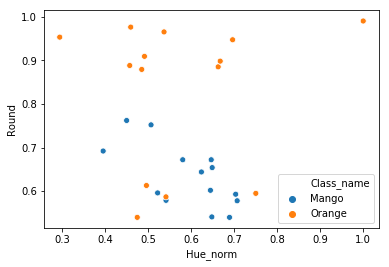

In [54]:
# Scatter plot of our train and test set
sns.scatterplot(data=data, x='Hue_norm', y='Round', hue='Class_name')

Arrange the needed matrices:
- **x** = $[x_0, x_1, x_2]$ where $x_0$ = 1.0, $x_1$ = first feature (Hue), and $x_2$ = second feature (Roundness) and 
- **Y** = actual class of the sample

In [6]:
# Train set
X1 = list(data['Hue_norm'])
X2 = list(data['Round'])
x = np.array(data[['x_0','Hue_norm','Round']]) 
Y = np.array(data[['Class']])

# Test set
X1_test = list(test['Hue_norm'])
X2_test = list(test['Round'])
x_test = np.array(test[['x_0','Hue_norm','Round']])
Y_test = np.array(test[['Class']])

## III - Perceptron
### A. Defining Functions
Here, we define functions for the perceptron algorithm.
1. *initial()* - function that returns the weights as a matrix of shape $3x1$ with randomized elements.
2. *lin()* - activation function (step function)
3. *predict()* - perceptron algorithm; utilizes the other two defined functions ( **Perceptron Model** )
4. *accuracy_metric()* - function that calculates the accuracy from the actual and prediction

In [7]:
# Function for weights
def initial():
    """
    Uses pseudo-random number generator to initialize our weights
    
    Returns
    -------  
        weigths: array (3x1)
            contains the initial weights for our perceptron. 
    """
    weights = np.random.randn(3,1)*0.1
    return weights 

In [8]:
# Activation function
def lin(x, weights):
    """
    Activation function: Step function
    
    Parameters
    ..........
        x -- contains the bias x_0 and the two 
              features of the samples: [x_0, x_1, x_2]
        weights -- initial weights (random, 3x1 matrix)
    
    Returns
    .......
        z -- array of shape (x.shape[1],1)
    """
    z = []
    a = np.dot(weights.T, x)
    for i in range(x.shape[1]):
        if a[0,i]>=0:
            b = 1
        else: 
            b = -1
        z.append([b])
    return z

In [9]:
# Perceptron Algorithm
def predict(x, y, weights, l_rate, iteration):
    """
    Activation function: Step function
    
    Parameters
        x: array | contains the bias x_0 and the two features of the samples: [x_0, x_1, x_2]       
        y: array | contains the actual values of the classes     
        weights: array | initial weights (random, 3x1 matrix)    
        l_rate: learning rate | scalar value usually of range 0 to 1  
        iteration: scalar
    
    Returns
        weights: array of shape (3,1)| updated weights
        layer1: array | prediction
    """
    error = []
    erf = []
    change = np.zeros((iteration//10, weights.shape[0]))
    for i in range(iteration):
        layer0 = x
        layer1 = lin(layer0.T, weights) # Activation function
        
        layer1_error = y-layer1 # calculates the error from the actual
        if (i%100) == 0:
            error.append(np.mean(np.abs(layer1_error)))
            print("Error after %s = %f" %(i, np.mean(np.abs(layer1_error)))) # displays error in decimal
        erf.append(0.5*np.sum(layer1_error)**2)
            
    # Updating weights:     
        dw = np.dot(layer1_error.T, x)/x.shape[0]
        weights = (weights+l_rate*dw.T)
         
        if (i%10) == 0:
#             a = i//100
            change[i//10,:] = (dw)
    
    layer1 = lin(layer0.T, weights) # Prediction
    return weights, layer1, error, change, erf

In [10]:
# Calculate accuracy percentage

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### B. Training model
We now utilize our defined function to train and test our model.

In [12]:
seed(42) # randomizer
init = initial() # initial weigths
iteration = 1000 # number of iteration
l_rate = 0.1

result, layer1, error, change, erf = predict(x, Y, init, l_rate, iteration) # Perceptron model
# layer1_update = lin(x.T, weights)
# layer1_update

score = accuracy_metric(layer1, Y) # scores (accuracy)

print("\nAccuracy=%f \n\n Initial weights = %s\n\n  Weights=%s" % (score, init, result))
layer1, Y

Error after 0 = 1.000000
Error after 100 = 1.000000
Error after 200 = 1.000000
Error after 300 = 0.785714
Error after 400 = 0.428571
Error after 500 = 0.285714
Error after 600 = 1.000000
Error after 700 = 0.714286
Error after 800 = 1.000000
Error after 900 = 1.000000

Accuracy=78.571429 

 Initial weights = [[ 0.01673849]
 [-0.04986655]
 [-0.15402551]]

  Weights=[[ 0.23816706]
 [-0.03743892]
 [-0.31247551]]


([[1],
  [1],
  [-1],
  [1],
  [1],
  [1],
  [1],
  [1],
  [1],
  [1],
  [1],
  [-1],
  [1],
  [1],
  [-1],
  [-1],
  [1],
  [-1],
  [-1],
  [-1],
  [1],
  [-1],
  [1],
  [-1],
  [-1],
  [-1],
  [-1],
  [1]],
 array([[ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [ 1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1],
        [-1]], dtype=int64))

We got the updated weights. We will now use this to obtain the equation of our decision line and then visualize it using matplotlib/seaborn.

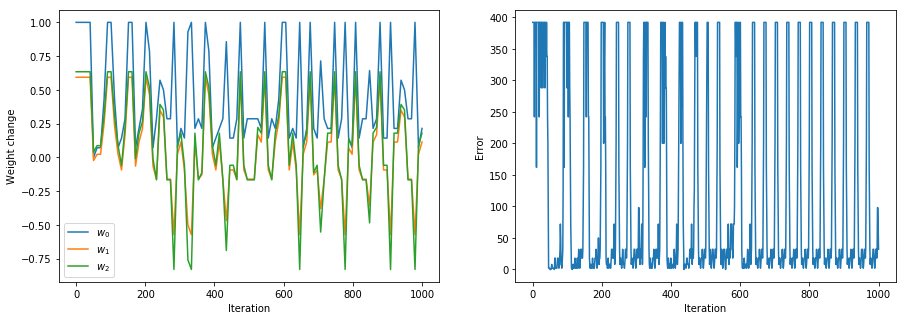

In [14]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.linspace(0,1000,100), np.abs(change[:,0]), label = '$w_0$')
ax[0].plot(np.linspace(0,1000,100), change[:,1], label = '$w_1$')
ax[0].plot(np.linspace(0,1000,100), change[:,2], label = '$w_2$')
ax[0].set_ylabel('Weight change')
ax[0].set_xlabel('Iteration')
ax[0].legend()
ax[1].plot(np.linspace(0,1000,1000), erf)
ax[1].set_ylabel('Error')
ax[1].set_xlabel('Iteration')

plt.savefig('ML2_weights_error_mvo.png')

### C. Testing and Visualizations
In this section, we will test the updated weights if it can predict the class of the features we will feed which are not yet seen by our model.

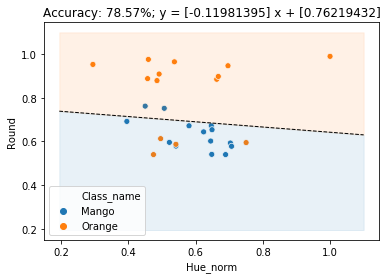

In [23]:
# Visualization for our training

b = -result[0]/result[2]   # y-intercept
m = -(result[1]/result[2]) # slope
f_x_train = b + np.dot(x[:,1].reshape(x.shape[0],1),m) # Decision line equation

xd_train = np.array([min(x[:,1])-0.1, max(x[:,1])+0.1]) # x-coordinate values
yd_train = m*xd_train + b                                     # set-up the line equation of the boundary

sns.scatterplot(data=data, x='Hue_norm', y='Round', hue='Class_name')
plt.plot(xd_train, yd_train,'--k', lw=1)
plt.fill_between(xd_train, yd_train, min(xd_train), color='tab:blue', alpha=0.1)
plt.fill_between(xd_train, yd_train, max(xd_train), color='tab:orange', alpha=0.1)
plt.title('Accuracy: %0.2f'%(score) +'%'+ '; y = %s x + %s' %(m, b))

plt.savefig('ML2_train_mvo.png')

In [ ]:
weights = result # updated weigths

layer1 = lin(x_test.T, weights)
scores = accuracy_metric(Y_test,layer1) 

print("\nAccuracy=%f \n\n  Weights=%s" % (scores, result))

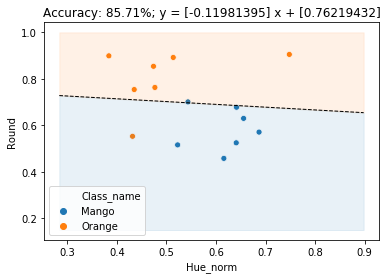

In [22]:
b = -result[0]/result[2]
m = -(result[1]/result[2])
f_x_test = b + np.dot(x_test[:,1].reshape(x_test.shape[0],1),m) # Decision line equation

xd = np.array([min(x_test[:,1])-0.1, max(x_test[:,1])+0.15])
yd = m*xd + b

sns.scatterplot(data=test, x='Hue_norm', y='Round', hue='Class_name')
plt.plot(xd,yd,'--k', lw=1)
plt.fill_between(xd, yd, 0.15, color='tab:blue', alpha=0.1)
plt.fill_between(xd, yd, 1, color='tab:orange', alpha=0.1)
plt.title('Accuracy: %0.2f'%(scores) +'%'+ '; y = %s x + %s' %(m, b))

plt.savefig('ML2_test_mvo.png')

## Banana vs Orange

In [24]:
# Additional column names: Hue, Class, and Class_name
orange['Hue'] = orange.apply(lambda x: hue(x['R'], x['G'], x['B']), axis = 1)
orange["Class"] = -1
banana['Hue'] = banana.apply(lambda x: hue(x['R'], x['G'], x['B']), axis = 1)
banana["Class"] = 1

orange["Class_name"] = 'Orange'
banana["Class_name"] = 'Banana'

In [25]:
# Train set
data = pd.concat([banana.iloc[0:14], orange.iloc[0:14]], ignore_index = True, sort = False) # Locate all 28 
data['Hue_norm'] = data['Hue']/max(data['Hue'])                                            # Normalize hue
data = data.drop(columns = ['Image', 'R', 'G', 'B', 'Skew'])                               # drop all unnecessary columns
data['x_0'] = 1.0                                                                          # For x_0 from the equation

# Test set
test = pd.concat([banana.iloc[14:], orange.iloc[14:]], ignore_index = True, sort = False)
test = test.drop(columns = ['Image', 'R', 'G', 'B', 'Skew'])
test['Hue_norm'] = test['Hue']/max(data['Hue'])
test['x_0'] = 1.0  

In [26]:
# Train set
X1 = list(data['Hue_norm'])
X2 = list(data['Round'])
x = np.array(data[['x_0','Hue_norm','Round']]) 
Y = np.array(data[['Class']])

# Test set
X1_test = list(test['Hue_norm'])
X2_test = list(test['Round'])
x_test = np.array(test[['x_0','Hue_norm','Round']])
Y_test = np.array(test[['Class']])

In [27]:
seed(42) # randomizer
init = initial() # initial weigths
iteration = 1000 # number of iteration
l_rate = 0.1

result, layer1, error, change, erf = predict(x, Y, init, l_rate, iteration) # Perceptron model
score = accuracy_metric(layer1, Y) # scores (accuracy)

print("\nAccuracy=%f \n\n Initial weights = %s\n\n  Weights=%s" % (score, init, result))

Error after 0 = 1.000000
Error after 100 = 0.500000
Error after 200 = 0.357143
Error after 300 = 0.500000
Error after 400 = 0.500000
Error after 500 = 0.500000
Error after 600 = 0.500000
Error after 700 = 0.571429
Error after 800 = 0.571429
Error after 900 = 0.357143

Accuracy=71.428571 

 Initial weights = [[-0.06268762]
 [-0.05026052]
 [-0.01336577]]

  Weights=[[ 0.05874095]
 [ 0.14091134]
 [-0.25454434]]


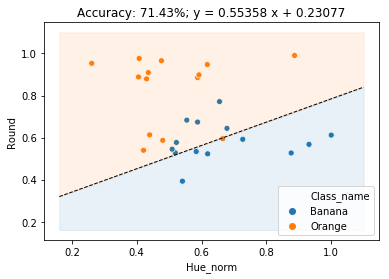

In [37]:
# Visualization for our training

b = -result[0]/result[2]   # y-intercept
m = -(result[1]/result[2]) # slope
f_x_train = b + np.dot(x[:,1].reshape(x.shape[0],1),m) # Decision line equation

xd_train = np.array([min(x[:,1])-0.1, max(x[:,1])+0.1]) # x-coordinate values
yd_train = m*xd_train + b                                     # set-up the line equation of the boundary

sns.scatterplot(data=data, x='Hue_norm', y='Round', hue='Class_name')
plt.plot(xd_train, yd_train,'--k', lw=1)
plt.fill_between(xd_train, yd_train, min(xd_train), color='tab:blue', alpha=0.1)
plt.fill_between(xd_train, yd_train, max(xd_train), color='tab:orange', alpha=0.1)
plt.title('Accuracy: %0.2f'%(score) +'%'+ '; y = %0.5f x + %0.5f' %(float(m), float(b)))

plt.savefig('ML2_train_bvo.png')

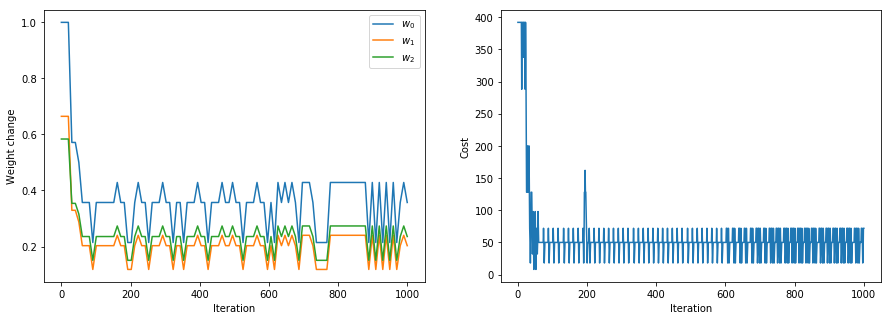

In [29]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.linspace(0,1000,100), np.abs(change[:,0]), label = '$w_0$')
ax[0].plot(np.linspace(0,1000,100), change[:,1], label = '$w_1$')
ax[0].plot(np.linspace(0,1000,100), change[:,2], label = '$w_2$')
ax[0].set_ylabel('Weight change')
ax[0].set_xlabel('Iteration')
ax[0].legend()
ax[1].plot(np.linspace(0,1000,1000), erf)
ax[1].set_ylabel('Cost')
ax[1].set_xlabel('Iteration')

plt.savefig('ML2_weights_error_bvso.png')

In [ ]:
weights = result # updated weigths

layer1 = lin(x_test.T, weights)
scores = accuracy_metric(Y_test,layer1) 

print("\nAccuracy=%f \n\n  Weights=%s" % (scores, result))

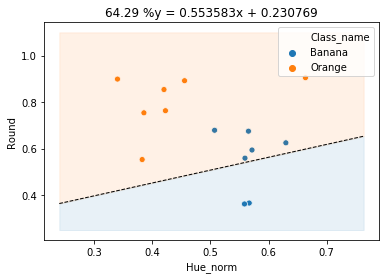

In [33]:
b = -result[0]/result[2]
m = -(result[1]/result[2])
f_x_test = b + np.dot(x_test[:,1].reshape(x_test.shape[0],1),m) # Decision line equation

xd = np.array([min(x_test[:,1])-0.1, max(x_test[:,1])+0.1])
yd = m*xd + b

sns.scatterplot(data=test, x='Hue_norm', y='Round', hue='Class_name')
plt.plot(xd,yd,'--k', lw=1)
plt.fill_between(xd, yd, 0.25, color='tab:blue', alpha=0.1)
plt.fill_between(xd, yd, 1.1, color='tab:orange', alpha=0.1)
plt.title('%0.2f ' %(float(scores)) + '%' + 'y = %fx + %f' %(m,b))

plt.savefig('ML2_test_bvso.png')

## Banana vs Mango

In [47]:
# Train set
data = pd.concat([banana.iloc[0:14], mango.iloc[0:14]], ignore_index = True, sort = False) # Locate all 28 
data['Hue_norm'] = data['Hue']/max(data['Hue'])                                            # Normalize hue
data = data.drop(columns = ['Image', 'R', 'G', 'B', 'Skew'])                               # drop all unnecessary columns
data['x_0'] = 1.0                                                                          # For x_0 from the equation

# Test set
test = pd.concat([banana.iloc[14:], mango.iloc[14:]], ignore_index = True, sort = False)
test = test.drop(columns = ['Image', 'R', 'G', 'B', 'Skew'])
test['Hue_norm'] = test['Hue']/max(data['Hue'])
test['x_0'] = 1.0  

In [46]:
# Additional column names: Hue, Class, and Class_name
mango['Hue'] = mango.apply(lambda x: hue(x['R'], x['G'], x['B']), axis = 1)
mango["Class"] = -1
banana['Hue'] = banana.apply(lambda x: hue(x['R'], x['G'], x['B']), axis = 1)
banana["Class"] = 1

mango["Class_name"] = 'Mango'
banana["Class_name"] = 'Banana'

In [48]:
# Train set
X1 = list(data['Hue_norm'])
X2 = list(data['Round'])
x = np.array(data[['x_0','Hue_norm','Round']]) 
Y = np.array(data[['Class']])

# Test set
X1_test = list(test['Hue_norm'])
X2_test = list(test['Round'])
x_test = np.array(test[['x_0','Hue_norm','Round']])
Y_test = np.array(test[['Class']])

In [49]:
seed(2) # randomizer
init = initial() # initial weigths
iteration = 1000 # number of iteration
l_rate = 0.1

result, layer1, error, change, erf = predict(x, Y, init, l_rate, iteration) # Perceptron model
score = accuracy_metric(layer1, Y) # scores (accuracy)

print("\nAccuracy=%f \n\n Initial weights = %s\n\n  Weights=%s" % (score, init, result))

Error after 0 = 1.000000
Error after 100 = 0.785714
Error after 200 = 0.785714
Error after 300 = 0.714286
Error after 400 = 0.642857
Error after 500 = 0.642857
Error after 600 = 0.642857
Error after 700 = 0.642857
Error after 800 = 0.714286
Error after 900 = 0.642857

Accuracy=67.857143 

 Initial weights = [[0.03760852]
 [0.04213319]
 [0.07841239]]

  Weights=[[-0.06239148]
 [ 0.56160343]
 [-0.33750904]]


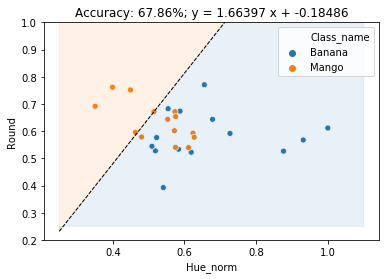

In [55]:
# Visualization for our training

b = -result[0]/result[2]   # y-intercept
m = -(result[1]/result[2]) # slope
f_x_train = b + np.dot(x[:,1].reshape(x.shape[0],1),m) # Decision line equation

xd_train = np.array([min(x[:,1])-0.1, max(x[:,1])+0.1]) # x-coordinate values
yd_train = m*xd_train + b                                     # set-up the line equation of the boundary

sns.scatterplot(data=data, x='Hue_norm', y='Round', hue='Class_name')
plt.plot(xd_train, yd_train,'--k', lw=1)
plt.fill_between(xd_train, yd_train, min(xd_train), color='tab:blue', alpha=0.1)
plt.fill_between(xd_train, yd_train, max(xd_train), color='tab:orange', alpha=0.1)
plt.title('Accuracy: %0.2f'%(score) +'%'+ '; y = %0.5f x + %0.5f' %(float(m), float(b)))
plt.ylim(min(xd_train)-0.05,1)
plt.savefig('ML2_train_bvm.png')

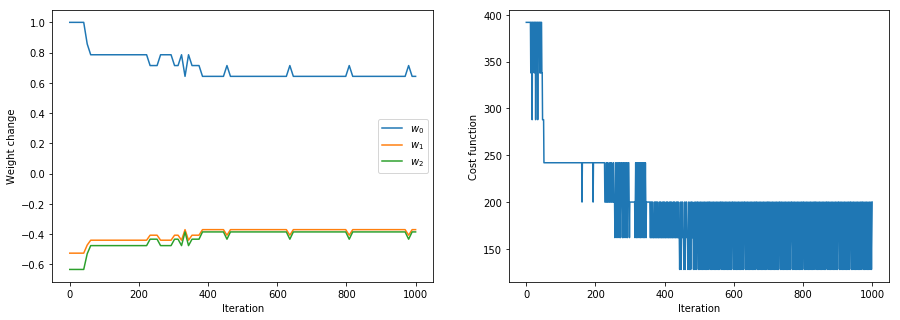

In [57]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(np.linspace(0,1000,100), np.abs(change[:,0]), label = '$w_0$')
ax[0].plot(np.linspace(0,1000,100), change[:,1], label = '$w_1$')
ax[0].plot(np.linspace(0,1000,100), change[:,2], label = '$w_2$')
ax[0].set_ylabel('Weight change')
ax[0].set_xlabel('Iteration')
ax[0].legend()
ax[1].plot(np.linspace(0,1000,1000), erf)
ax[1].set_ylabel('Cost function')
ax[1].set_xlabel('Iteration')

plt.savefig('ML2_weights_error_bvsm.png')

In [ ]:
weights = result # updated weigths

layer1 = lin(x_test.T, weights)
scores = accuracy_metric(Y_test,layer1) 

print("\nAccuracy=%f \n\n  Weights=%s" % (scores, result))

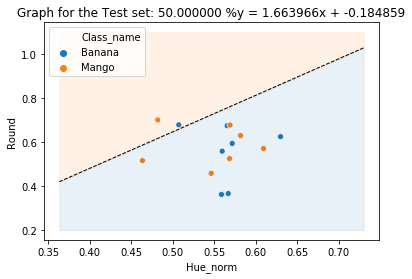

In [60]:
b = -result[0]/result[2]
m = -(result[1]/result[2])
f_x_test = b + np.dot(x_test[:,1].reshape(x_test.shape[0],1),m) # Decision line equation

xd = np.array([min(x_test[:,1])-0.1, max(x_test[:,1])+0.1])
yd = m*xd + b

sns.scatterplot(data=test, x='Hue_norm', y='Round', hue='Class_name')
plt.plot(xd,yd,'--k', lw=1)
plt.fill_between(xd, yd, 0.2, color='tab:blue', alpha=0.1)
plt.fill_between(xd, yd, 1.1, color='tab:orange', alpha=0.1)
plt.title('Graph for the Test set: %f ' %(float(scores)) + '%' + 'y = %fx + %f' %(m,b))

plt.savefig('ML2_test_bvsm.png')

#### Let's get all the decision lines and overlay them in the scatterplot of our dataset

In [72]:
m0 = 0.11981395
m1 = 0.553583
m2 = 1.663966
b0 = 0.76219432
b1 = 0.230769
b2 = -0.184859

# Train set
data1 = pd.concat([mango.iloc[0:14], orange.iloc[0:14], banana.iloc[0:14]], ignore_index = True, sort = False) # Locate all 28 
data1['Hue_norm'] = data1['Hue']/max(data1['Hue'])                                            # Normalize hue
data1 = data1.drop(columns = ['Image', 'R', 'G', 'B', 'Skew'])                               # drop all unnecessary columns
data1['x_0'] = 1.0                                                                          # For x_0 from the equation

# Test set
test1 = pd.concat([mango.iloc[14:], orange.iloc[14:], banana.iloc[14:]], ignore_index = True, sort = False)
test1 = test1.drop(columns = ['Image', 'R', 'G', 'B', 'Skew'])
test1['Hue_norm'] = test1['Hue']/max(data['Hue'])
test1['x_0'] = 1.0  

In [62]:
# Train set
X1 = list(data['Hue_norm'])
X2 = list(data['Round'])
x = np.array(data[['x_0','Hue_norm','Round']]) 
Y = np.array(data[['Class']])

# Test set
X1_test = list(test['Hue_norm'])
X2_test = list(test['Round'])
x_test = np.array(test[['x_0','Hue_norm','Round']])
Y_test = np.array(test[['Class']])

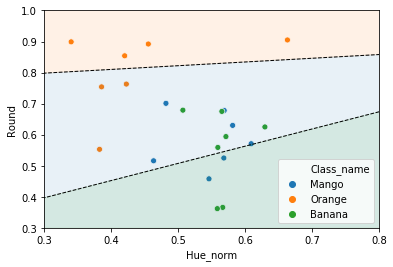

In [96]:
# b = -result[0]/result[2]
# m = -(result[1]/result[2])
# f_x_test = b + np.dot(x_test[:,1].reshape(x_test.shape[0],1),m) # Decision line equation

xd = np.array([min(x[:,1])-0.1, max(x[:,1])+0.1])
yd = m*xd + b

sns.scatterplot(data=test1, x='Hue_norm', y='Round', hue='Class_name')
plt.plot(xd,m0*xd + b0,'--k', lw=1)
plt.plot(xd,m1*xd + b1,'--k', lw=1)
# plt.plot(xd,m2*xd + b2,'--k', lw=1)

plt.fill_between(xd, m0*xd + b0, 0.2, color='tab:blue', alpha=0.1)
plt.fill_between(xd, m0*xd + b0, 1.1, color='tab:orange', alpha=0.1)

plt.fill_between(xd, m1*xd + b1, 0.3, color='tab:green', alpha=0.1)
# plt.fill_between(xd, m1*xd + b1, 1.1, color='tab:orange', alpha=0.1)

# plt.fill_between(xd, m2*xd + b2, 0.3, color='tab:green', alpha=0.1)
# plt.fill_between(xd, m2*xd + b2, 0.75, color='tab:blue', alpha=0.1)
plt.ylim(0.3,1)
plt.xlim(0.3,0.8)
# plt.title('Graph for the Test set: %f ' %(float(scores)) + '%' + 'y = %fx + %f' %(m,b))

plt.savefig('ML2_test_bvsmvso.png')